In [29]:
import pandas as pd
import pdal
import json
import laspy
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point, Polygon

In [9]:
class FetchAndLoad():
    '''
    params : 
        polygon : polygon of area we need to crop
        state : state to do the elevation
    
    instruction:
        Make sure to run them sequentially.
        run_pipe() : will generate the neccessary files
        create_geopandasdf() : generate data frame from the files
        get_geopandas_df() : will provide the data frame
        
    '''
    def __init__(self, polygon:Polygon, epsg:int=4326, state='IA_FullState'):
        self.polygon = polygon

        self.state = state
        self.epsg = epsg
        self.bounds = None
        self.crs_polygon = None
        
        self.pipe_path = './pipeline.json'
        self.las_path = self.state+'.las'
        self.tif_path = self.state+'.tif'
        self.api_path = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"+self.state+"/ept.json"
        
        self.pipeline = None
        
        self.las_file = None
        self.points = None
        self.elevation = None
        self.geo_df = None
        
        
    def read_json(self):
      '''
      Read json file and return the string format
      '''

      try:
        file_path = self.pipe_path
        print("File Path : ", file_path)
        with open(file_path, 'r') as json_file:
          data = json.loads(json_file.read())
        return data

      except:
        print('File Not found')
        return None
    
    def get_bounds_and_ploygon(self):
        '''
        set bounderies and polygons after converting user CRS - coordinate system
        to the coordinate system we use ( 3857 ).
        '''
        polygon_df = gpd.GeoDataFrame([self.polygon], columns=['geometry'])
        
        polygon_df.set_crs(epsg=self.epsg, inplace=True)
        polygon_df['geometry'] = polygon_df['geometry'].to_crs(
            epsg=3857)
        minx, miny, maxx, maxy = polygon_df['geometry'][0].bounds
        
        polygon_input = 'POLYGON(('

        xcord, ycord = polygon_df['geometry'][0].exterior.coords.xy
        for x, y in zip(list(xcord), list(ycord)):
            polygon_input += f'{x} {y}, '
        polygon_input = polygon_input[:-2]
        polygon_input += '))'
        
        
        self.bounds = f"({[minx, maxx]},{[miny,maxy]})"
        self.crs_polygon = polygon_input
        
        
    def prepare_pipe(self):
        '''
        Populate The pipe line with boundary, and return pipeline
        '''
        self.get_bounds_and_ploygon()
        data = self.read_json()
        data['pipeline'][0]['bounds'] = self.bounds
        data['pipeline'][0]['filename'] = self.api_path
        
        data['pipeline'][1]['polygon'] = self.crs_polygon
        
        data['pipeline'][4]['out_srs'] = f'EPSG:{self.epsg}'

        data['pipeline'][7]['filename'] = self.las_path
        data['pipeline'][8]['filename'] = self.tif_path


        print("data LInk : " , data['pipeline'][0]['filename'])
        self.pipeline = data
        
    
    def run_pipe(self):
        '''
        Generate .las and .tif file from the pipeline
        '''
        print("Run pipe ...")
        result = self.prepare_pipe()
        pdal_pipe = pdal.Pipeline(json.dumps(self.pipeline))
        pdal_result = pdal_pipe.execute()
        print("Fetching Completed!")
        
        
    def read_laz(self):
        '''
        Read Generated Las file
        Return laspy read las file
        '''
        try:
            print("Reading Las File from :", self.las_path)
            las = laspy.read(self.las_path)
            self.las_file = las
            return las
        
        except FileNotFoundError:
            print("Log: File Not found")
            print("Please use the function run_pipe before this funciton")
            
    
    def generate_points_elevation(self):
        '''
        Return Points (x, y) and elevation (z)
        '''
        print("Generating Points from las File ...")
        points = [Point(x, y) for x,y in zip(self.las_file.x, self.las_file.y)]
        elevation = np.array(self.las_file.z)
        
        self.points, self.elevation = points, elevation
        print("Finished Generating Points!")
        
        return points, elevation
    
    
    def create_geopandasdf(self):
        '''
        Return Geopandas data frame from elevation and geometic points
        '''
        self.read_laz()
        self.generate_points_elevation()
        
        print("Making Geopandas Data Frame...")
        geopanda_df = gpd.GeoDataFrame({"elevation": self.elevation, "geometry":self.points})
        geopanda_df.set_geometry('geometry')
        geopanda_df.set_crs(epsg=4326, inplace=True)
        
        self.geo_df = geopanda_df
        print("Finished Making Geopandas Data Frame!")
        return geopanda_df
    
    
    def get_geopandas_df(self):
        return self.geo_df
        
    

### Initial Inputs

In [17]:
MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.747334, 41.921429]

# MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.756055, 41.918115]

polygon = Polygon(((MINX, MINY), (MINX, MAXY),
                   (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))



check = FetchAndLoad(polygon)
check.run_pipe()

Run pipe ...
File Path :  ./pipeline.json
data LInk :  https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json
Fetching Completed!


### Generating Geopandas DF from las file

In [18]:
check.create_geopandasdf()
new_result =  check.get_geopandas_df()

Reading Las File from : IA_FullState.las
Generating Points from las File ...
Finished Generating Points!
Making Geopandas Data Frame...
Finished Making Geopandas Data Frame!


In [19]:
new_result.head()

,elevation,geometry
0,318.49,POINT (-93.75000 41.92000)
1,318.37,POINT (-93.75000 41.92000)
2,318.41,POINT (-93.75000 41.92000)
3,318.15,POINT (-93.75000 41.92000)
4,318.29,POINT (-93.75000 41.92000)


In [35]:
# new_result.to_csv('IA_FullState.csv', index=False)

In [26]:
def get_geopandas_df(elevation, points):
    geopanda_df = gpd.GeoDataFrame({"elevation":elevation, "geometry":points})
    geopanda_df.set_geometry('geometry')
    geopanda_df.set_crs(epsg=4326, inplace=True)
    return geopanda_df

In [30]:
read_geo_csv = pd.read_csv('IA_FullState.csv')


In [31]:
read_geo_csv.head()

,elevation,geometry
0,318.49,POINT (-93.75 41.92)
1,318.37,POINT (-93.75 41.92)
2,318.41,POINT (-93.75 41.92)
3,318.15,POINT (-93.75 41.92)
4,318.29,POINT (-93.75 41.92)


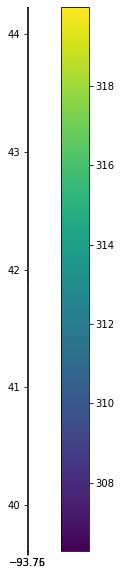

In [25]:
## Todo, Add Year and return the Data frame.

## Save the data frame if possible.
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(12, 10))

new_result.plot(column='elevation', ax=ax, legend=True)
plt.show()

In [39]:
import numpy as np
import laspy as lp

point_cloud=lp.read("IA_FullState.las")

In [40]:
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

In [41]:
factor=160
decimated_points_random = points[::factor]

In [42]:
voxel_size=6
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)

In [43]:
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)

In [44]:
voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

In [46]:
for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= points[idx_pts_vox_sorted[
    last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(
       voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] -
       np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

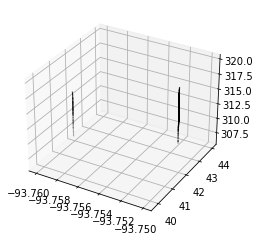

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
decimated_colors = colors[::factor]
ax = plt.axes(projection='3d')
ax.scatter(decimated_points_random[:,0], decimated_points_random[:,1], decimated_points_random[:,2], c = decimated_colors/65535, s=0.01)
plt.show()